<a href="https://colab.research.google.com/github/Kaushal-Top5699/visual_ques_ans/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from collections import defaultdict
import random
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
#from keras_preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam
import json
from tensorflow.keras import initializers 
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,SpatialDropout1D
from tensorflow.keras.layers import multiply
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

2023-05-09 17:53:58.513801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading Anotations

In [ ]:
annotation_link_train = "/Users/kaushaltop/Downloads/abstract_v002_train2015_annotations.json"
annoatation_data = json.load(open(annotation_link_train))

In [ ]:
ann_train = pd.DataFrame(annoatation_data["annotations"])
ann_train.head()

question_type multiple_choice_answer  \
0           who                    man   
1  where is the                blanket   
2  where is the                  bench   
3       is this                    yes   
4  what kind of                   soda   

                                             answers  image_id answer_type  \
0  [{'answer': 'old person', 'answer_confidence':...     11779       other   
1  [{'answer': 'on blanket', 'answer_confidence':...     11779       other   
2  [{'answer': 'on bench', 'answer_confidence': '...     11779       other   
3  [{'answer': 'yes', 'answer_confidence': 'yes',...      5536      yes/no   
4  [{'answer': 'water', 'answer_confidence': 'no'...      5536       other   

   question_id  
0       117792  
1       117790  
2       117791  
3        55360  
4        55361

In [ ]:
cat_count = pd.DataFrame(ann_train['multiple_choice_answer'].value_counts())
# print(cat_count.to_string())

## Reading Questions

In [ ]:
mcq_link_train = "/Users/kaushaltop/Downloads/Questions_Train_abstract_v002/MultipleChoice_abstract_v002_train2015_questions.json"
mcq_data = json.load(open(mcq_link_train))

In [ ]:
mcq_train = pd.DataFrame(mcq_data["questions"])
mcq_train.head()

image_id                     question  \
0     11779           Who looks happier?   
1     11779  Where is the woman sitting?   
2     11779    Where is the man sitting?   
3      5536          Is this man hungry?   
4      5536  What kind of drink is that?   

                                    multiple_choices  question_id  
0  [alive, 1, woman, purple, 2, yes, white, boy, ...       117792  
1  [3, no, blue, red, 1, slide, monkey bars, jump...       117790  
2  [away, yes, blue, 1, 2, mouse, couch, no, yell...       117791  
3  [water, yellow, 4, running, blue, pouring, out...        55360  
4  [wine, girl would fall, soda, white, yes, coke...        55361

Functions to generate file names from image IDs.

Change the below code!!

In [ ]:
def append_zeros(id): # sub function to return img id padded with zeros
    arr = ["0","0","0","0","0","0","0","0","0","0","0","0"]
    count = 0
    for i in range(len(id)-1, -1,-1):
        arr[count] = id[i]
        count += 1
    return "".join(arr[::-1])
    
# Function to return the file name correponding to image id
# if type argument is passed as 't' then return will contain train file name
# else validation file name
def img_id_2_filename(image_id, type = 't'):
    img_id = str(image_id)
    if type == 't':
        file_name = "abstract_v002_train2015_"
    else:
        file_name = "abstract_v002_val2015_"
    s = append_zeros(img_id)
    return file_name + s + ".png"

### Join the annotations and questions dataframe on baiss of question_id and then select columns that are required for training.

In [ ]:
train_df = ann_train.merge(mcq_train, how = "inner", on = "question_id")
train_df = train_df[["image_id_x", "question", "multiple_choice_answer"]]
train_df.head()

image_id_x                     question multiple_choice_answer
0       11779           Who looks happier?                    man
1       11779  Where is the woman sitting?                blanket
2       11779    Where is the man sitting?                  bench
3        5536          Is this man hungry?                    yes
4        5536  What kind of drink is that?                   soda

### Select only those questions whose output is numerical value.
Do we have to follow the same or we have to consider all questions?

In [ ]:
df_dummy = pd.DataFrame(columns=['image_id_x', 'question', 'multiple_choice_answer'])
for i in range(len(train_df)):
    try:
        x = int(train_df['multiple_choice_answer'].iloc[i])
        df_dummy = df_dummy.append(train_df.iloc[i])
    except:
        continue

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dummy = df_dummy.append(train_df.iloc[i])
/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/4044989725.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

In [ ]:
df_dummy.head()

image_id_x                                question multiple_choice_answer
22      10005                       How many pillows?                      2
24       1527        How many people are in the room?                      1
36      15492  How many bushes are in the background?                      3
40       1329             How many logs on the grass?                      2
43      14657             How many mice are crawling?                      3

### We can select all types questions if we want.

### Now lets get the 80,000 training images.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Checking the 3000 images.

In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/Train')
# !ls

In [ ]:
path = "/Users/kaushaltop/Desktop/train_images/"
df_dummy['Image_path'] = ""
for i in range(len(df_dummy)):
    df_dummy['Image_path'].iloc[i] = path + img_id_2_filename(df_dummy['image_id_x'].iloc[i])

In [ ]:
df_dummy.head()

image_id_x                                question multiple_choice_answer  \
22      10005                       How many pillows?                      2   
24       1527        How many people are in the room?                      1   
36      15492  How many bushes are in the background?                      3   
40       1329             How many logs on the grass?                      2   
43      14657             How many mice are crawling?                      3   

                                           Image_path  
22  /Users/kaushaltop/Desktop/train_images/abstrac...  
24  /Users/kaushaltop/Desktop/train_images/abstrac...  
36  /Users/kaushaltop/Desktop/train_images/abstrac...  
40  /Users/kaushaltop/Desktop/train_images/abstrac...  
43  /Users/kaushaltop/Desktop/train_images/abstrac...

### We have access to images.

Now we can drop image_id_x coloumn.

In [ ]:
train_df = df_dummy.drop('image_id_x',axis=1)

In [ ]:
train_df.head()

question multiple_choice_answer  \
22                       How many pillows?                      2   
24        How many people are in the room?                      1   
36  How many bushes are in the background?                      3   
40             How many logs on the grass?                      2   
43             How many mice are crawling?                      3   

                                           Image_path  
22  /Users/kaushaltop/Desktop/train_images/abstrac...  
24  /Users/kaushaltop/Desktop/train_images/abstrac...  
36  /Users/kaushaltop/Desktop/train_images/abstrac...  
40  /Users/kaushaltop/Desktop/train_images/abstrac...  
43  /Users/kaushaltop/Desktop/train_images/abstrac...

How an image, question and answer looks like?

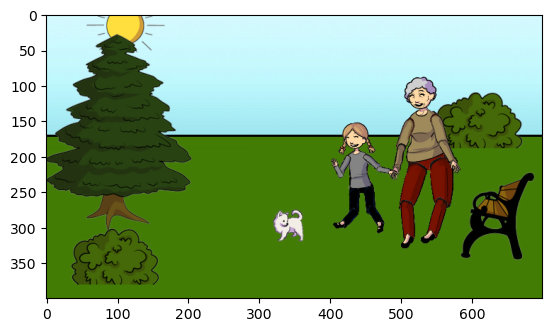

How many people are there?
2


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# Select a row from the DataFrame
row_no = random.randint(0, 1000)
img_name = train_df.iloc[row_no]['Image_path']

# Open the image and display it using Matplotlib
image = Image.open(img_name)
plt.imshow(image)
plt.show()

# Print the corresponding question and answer from the DataFrame
print(train_df.iloc[row_no]["question"])
print(train_df.iloc[row_no]["multiple_choice_answer"])

In [ ]:
def read_image(image_name):
    image = Image.open(os.path.join(image_name))
    image = image.convert('RGB')  # convert images to RGB as some are in RGBA format
    my_arr = np.asarray(image.resize((224,224))) / 255.0  # resize and normalize
    return my_arr[None, :]

In [ ]:
import tensorflow as tf

vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
VGG16Model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [ ]:
VGG16Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
row_no = 502
img_name = train_df.iloc[row_no]['Image_path']
image = read_image(img_name)
encoded_image = VGG16Model.predict(image)
print(encoded_image.shape)

file_names_train = train_df["Image_path"].drop_duplicates().values
print(file_names_train[1])

1/1 [==============================] - 0s 500ms/step
(1, 4096)
/Users/kaushaltop/Desktop/train_images/abstract_v002_train2015_000000001527.png


In [ ]:
def img_generator(img_list):
    for img in img_list:
        out_image = read_image(img)
        yield out_image

In [ ]:
enc_train = VGG16Model.predict(img_generator(file_names_train), steps=len(file_names_train), verbose=1)

2023-05-09 18:18:11.112207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7490/7490 [==============================] - 1230s 164ms/step


In [ ]:
print(enc_train.shape)
np.save("encoded_images_train_VGG.npy", enc_train)

(7490, 4096)


# LSTM

In [ ]:
max_len = 0
for i in train_df['question'].values:
    if len(i.split(" ")) > max_len:
        max_len = len(i.split(" "))

print(max_len)

17


In [ ]:
def ques_equivate_len(ques_arr):
    ret_arr = []
    for i in range(18):
        try:
            if ques_arr[i] != " ":
                ret_arr.append(ques_arr[i])
            else:
                ret_arr.append("#")
        except:
            ret_arr.append("#")
    return ret_arr

In [ ]:
# create a set of all words from questions and multiple choices 
mcq_train_questions = train_df['question'].values
mcq_train_choices = train_df['multiple_choice_answer'].drop_duplicates().values
#print(mcq_train_choices)

some_set = set()
for some_question in mcq_train_questions:
    words = some_question.lower().split(" ")
    for i in words:
        some_set.add(i)

print(len(some_set))

for ans in mcq_train_choices:
    some_set.add(ans)
print(len(some_set))

some_set.add("#")
#some_set.add(" ")
#some_set.add("w")

print(len(some_set))

some_list = list(some_set)
some_list.sort()

1454
1490
1491


In [ ]:
int_to_word = {}
word_to_int = {}
for int1 in range(len(some_list)):
  word = some_list[int1]
  int_to_word[int1] = word
  word_to_int[word] = int1

In [ ]:
int_to_word[1000]

'playground?'

In [ ]:
word_to_int['playground?']

1000

In [ ]:
answer_list = train_df['multiple_choice_answer'].drop_duplicates().values

In [ ]:
def convert_to_numbers(string_arr):
    return [word_to_int[i] for i in string_arr]

def convert_to_words(num_arr):
    return [int_to_word[i] for i in num_arr]

def generator_func(ans_list = answer_list, batch_size = 128):
    bcount = 0
    ques = []
    image = []
    answer = []

    while True:
        for i in range(len(train_df)):
            img_name = train_df['Image_path'].iloc[i]
            
            ques_string = train_df['question'].iloc[i]
            ques_string = np.asarray(convert_to_numbers(ques_equivate_len(ques_string.lower().split(" "))))

            answ = train_df['multiple_choice_answer'].iloc[i]
            #print(answer_string)
            answer_string = np.zeros(38)
            #print(ans_list)
            for i in range(38):
                if ans_list[i] == answ:
                    answer_string[i] = 1
            #print(answer_string)


            #print(img_name, ques_string, answer_string)
            enc_img_ind = np.where(file_names_train == img_name)[0][0]
            enc_image = enc_train[enc_img_ind]
            ques.append(ques_string)
            image.append(enc_image)
            answer.append(answer_string)
            bcount += 1

            if bcount >= batch_size:
                yield [[np.asarray(image), np.asarray(ques)], np.asarray(answer)]
                ques = []
                image = []
                answer = []
                bcount = 0

In [ ]:
#Creating image model 
img_in = tf.keras.layers.Input(shape=(4096,))
train_image = tf.keras.layers.Dense(1024,activation='relu')(img_in)
train_image = Model(inputs=img_in,outputs=train_image)
train_image.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense_3 (Dense)             (None, 1024)              4195328   
                                                                 
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vocab_len = len(word_to_int)

In [ ]:
QUES_MAX_LEN = 18

#Lstm model for Questions
ques_in = Input(shape=(QUES_MAX_LEN,))
embedding1 =Embedding(vocab_len, 300, input_length=QUES_MAX_LEN,trainable=False)(ques_in)
#lst1= LSTM(64,kernel_initializer=initializers.he_normal(seed=42),kernel_regularizer=l2(0.001),return_sequences=True)(embedding1)
#lst2= LSTM(64,kernel_initializer=initializers.he_normal(seed=42),kernel_regularizer=l2(0.001),return_sequences=True)(lst1)
lone= LSTM(64,return_sequences=True)(embedding1)
ltwo= LSTM(64,return_sequences=True)(lone)
flat = Flatten(name='flatten_1')(ltwo)
ques_model=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(flat)
ques_model = Model(inputs=ques_in, outputs=ques_model)
ques_model.summary()

2023-05-09 18:45:08.676943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 18:45:08.678131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 18:45:08.679759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 18, 300)           447300    
                                                                 
 lstm_2 (LSTM)               (None, 18, 64)            93440     
                                                                 
 lstm_3 (LSTM)               (None, 18, 64)            33024     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              1180672   
                                                                 
Total params: 1,754,436
Trainable params: 1,307,136
Non-tra

In [ ]:
#Fusion model
fusion_model = multiply([train_image.layers[-1].output,ques_model.layers[-1].output])
dnn1 = BatchNormalization()(fusion_model)
dnn1 = Dropout(0.5)(dnn1)
dnn1 = Dense(1000,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(dnn1)
CombinedOutput = Dense(38, kernel_initializer=initializers.he_normal(seed=42),activation='softmax')(dnn1)
FinalModel = Model(inputs=[img_in,ques_in], outputs=CombinedOutput)
print(FinalModel.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 18, 300)      447300      ['input_7[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 18, 64)       93440       ['embedding_1[0][0]']            
                                                                                                  
 lstm_3 (LSTM)                  (None, 18, 64)       33024       ['lstm_2[0][0]']                 
                                                                                            

In [ ]:
FinalModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 
batch_size = 128
generator = generator_func(answer_list, batch_size)
steps = len(file_names_train) * QUES_MAX_LEN // batch_size 

In [ ]:
hist = FinalModel.fit(generator, steps_per_epoch=steps, epochs=5, verbose=1)

Epoch 1/5


2023-05-09 18:45:48.903760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-09 18:45:49.206344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 18:45:49.208706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

1053/1053 [==============================] - 93s 84ms/step - loss: 1.4216 - accuracy: 0.4625
Epoch 2/5
1053/1053 [==============================] - 92s 87ms/step - loss: 1.0975 - accuracy: 0.5681
Epoch 3/5
1053/1053 [==============================] - 89s 85ms/step - loss: 0.9111 - accuracy: 0.6391
Epoch 4/5
1053/1053 [==============================] - 86s 82ms/step - loss: 0.7682 - accuracy: 0.6970
Epoch 5/5
1053/1053 [==============================] - 88s 83ms/step - loss: 0.6689 - accuracy: 0.7352


In [ ]:
FinalModel.save_weights("VQA_model_weights_VGG.h5")
FinalModel.save_weights("VQA_model_weights_VGG_1.h5")
FinalModel.save_weights("VQA_model_weights_VGG_2.h5")
FinalModel.load_weights("VQA_model_weights_VGG.h5")
FinalModel.load_weights("VQA_model_weights_VGG_2.h5")

In [ ]:
def decode(enc_img, tokenized_ques, tokenized_choices):
    # write code
    pred = FinalModel.predict([enc_img, tokenized_ques])
    arr = []
    for i in range(38):
        arr.append(pred[0,i])
    pd_prob = pd.DataFrame({'Answer': tokenized_choices, 'Prob': arr})
    pd_prob = pd_prob.sort_values('Prob',ascending=False)
    print(pd_prob[:4].to_string(index=False))

In [ ]:
enc_train = np.load("encoded_images_train_VGG.npy")

How many slices of watermelon are there?
2


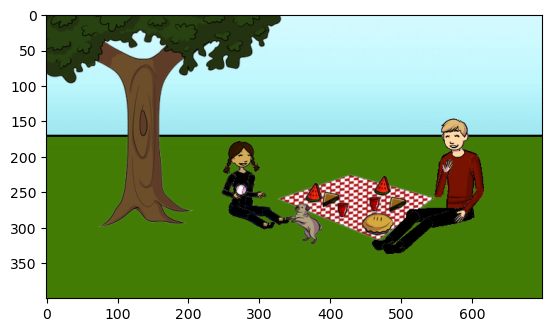

1/1 [==============================] - 0s 227ms/step
Answer     Prob
     3 0.775308
     2 0.143764
     1 0.080926
     4 0.000002


In [ ]:
import tensorflow as tf

rand_ind = 5
ind_p = 0
img1 = np.asarray([enc_train[rand_ind]])
print(train_df[train_df['Image_path'] == file_names_train[rand_ind]]['question'].iloc[0])
print(train_df[train_df['Image_path'] == file_names_train[rand_ind]]['multiple_choice_answer'].iloc[0])
ques = np.asarray([convert_to_numbers(ques_equivate_len(train_df[train_df['Image_path'] == file_names_train[rand_ind]]['question'].iloc[0].lower().split(" ")))])
ans = np.asarray([convert_to_numbers([train_df[train_df['Image_path'] == file_names_train[rand_ind]]['multiple_choice_answer'].iloc[0]])])

image = Image.open(os.path.join(file_names_train[rand_ind]))
plt.imshow(image)
plt.show()

decode(img1, ques, answer_list)

In [ ]:
## Working with Validation

In [ ]:
annotations_link_val = "/Users/kaushaltop/Downloads/abstract_v002_val2015_annotations.json"
ann_val_data = json.load(open(annotations_link_val))

In [ ]:
ann_val = pd.DataFrame(ann_val_data["annotations"])
ann_val.head()

question_type multiple_choice_answer  \
0         is the dog                    yes   
1    what is the man                     tv   
2         is the man                    yes   
3  none of the above                    yes   
4            what is             wine glass   

                                             answers  image_id answer_type  \
0  [{'answer': 'yes', 'answer_confidence': 'yes',...     27578      yes/no   
1  [{'answer': 'tv', 'answer_confidence': 'yes', ...     27578       other   
2  [{'answer': 'yes', 'answer_confidence': 'yes',...     27578      yes/no   
3  [{'answer': 'yes', 'answer_confidence': 'yes',...     21768      yes/no   
4  [{'answer': 'wine glass', 'answer_confidence':...     21768       other   

   question_id  
0       275780  
1       275781  
2       275782  
3       217680  
4       217681

In [ ]:
mcq_link_val = "/Users/kaushaltop/Downloads/Questions_Val_abstract_v002/MultipleChoice_abstract_v002_val2015_questions.json"
mcq_val_data = json.load(open(mcq_link_val))

In [ ]:
mcq_val = pd.DataFrame(mcq_val_data["questions"])
mcq_val.head()

image_id                                       question  \
0     27578                             Is the dog asleep?   
1     27578                    What is the man looking at?   
2     27578             Is the man sitting on the armrest?   
3     21768                          Did she bake the pie?   
4     21768  What is resting on the table besides the pie?   

                                    multiple_choices  question_id  
0  [white, picnicking, yes, hot, dog and girl, bl...       275780  
1  [monkey bars, drinking, dog, red, blue, son, b...       275781  
2  [2, brown, wider, sitting, yes, marriage, red,...       275782  
3  [golden girls, sky, 1, blue, 2, 4, no, feeding...       217680  
4  [brown, air, cumulus, no, it is playing, wine ...       217681

In [ ]:
df_dummy = ann_val.merge(mcq_val, how='inner', on='question_id')
df_dummy = df_dummy[df_dummy['question_type'] == 'how many']
df_dummy = df_dummy[df_dummy['multiple_choice_answer'] != 'many']
print(df_dummy['multiple_choice_answer'].drop_duplicates().values)

['3' '2' '5' '1' '0' '4' '6' '18' '7' '16' '11' '8' '10' '14' '9' '15'
 '12' '20' '17' '21']


In [ ]:
df_dummy = df_dummy[['question', 'multiple_choice_answer', 'image_id_x']]
df_dummy.head()

question multiple_choice_answer  \
11         How many Teacups are on the table?                      3   
26                           How many clouds?                      2   
51   How many steps are on the sliding board?                      5   
85               How many plants in the room?                      1   
104         How many flowers are in the room?                      0   

     image_id_x  
11        25841  
26        29804  
51        26002  
85        28492  
104       29865

### Get Validation Image DataSet

In [ ]:
path = "/Users/kaushaltop/Desktop/val_images/"
df_dummy['Image_path'] = ""
for i in range(len(df_dummy)):
    df_dummy['Image_path'].iloc[i] = path + img_id_2_filename(df_dummy['image_id_x'].iloc[i],'v')

/var/folders/ys/5fz1rj1d0rs6wg2rjs801z000000gn/T/ipykernel_37959/3650236040.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['Image_path'].iloc[i] = path + img_id_2_filename(df_dummy['image_id_x'].iloc[i],'v')


In [ ]:
val_df = df_dummy.drop('image_id_x',axis=1)

In [ ]:
val_df.head()

question multiple_choice_answer  \
11         How many Teacups are on the table?                      3   
26                           How many clouds?                      2   
51   How many steps are on the sliding board?                      5   
85               How many plants in the room?                      1   
104         How many flowers are in the room?                      0   

                                            Image_path  
11   /Users/kaushaltop/Desktop/val_images/abstract_...  
26   /Users/kaushaltop/Desktop/val_images/abstract_...  
51   /Users/kaushaltop/Desktop/val_images/abstract_...  
85   /Users/kaushaltop/Desktop/val_images/abstract_...  
104  /Users/kaushaltop/Desktop/val_images/abstract_...

### 30 Predictions on Val DataSet

In [ ]:
import tensorflow as tf

rand_ind = random.randint(0, 1000)
val_df['question'].iloc[5]
print(val_df['question'].iloc[rand_ind])
print(val_df['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(val_df['question'].iloc[rand_ind].lower().split(" ")))])

img_name = val_df.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = val_df.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

1/1 [==============================] - 0s 185ms/step


In [ ]:
import tensorflow as tf
def print_predictions(n_preds, val_df, answer_list):
    while n_preds != 0:
        rand_ind = random.randint(0, 30)
        n_preds -= 1
        val_df['question'].iloc[5]
        question = val_df['question'].iloc[rand_ind]
        answers_mcq = val_df['multiple_choice_answer'].iloc[rand_ind]
        print(question)
        print(answers_mcq)
        ques = np.asarray([convert_to_numbers(ques_equivate_len(val_df['question'].iloc[rand_ind].lower().split(" ")))])
        img_name = val_df.iloc[rand_ind]['Image_path']
        image = Image.open(os.path.join(img_name))
        plt.imshow(image)
        plt.show()
        img_name = val_df.iloc[rand_ind]['Image_path']
        image = read_image(img_name)
        img1 = VGG16Model.predict(image)
        decode(img1, ques, answer_list)

How many balls?
1


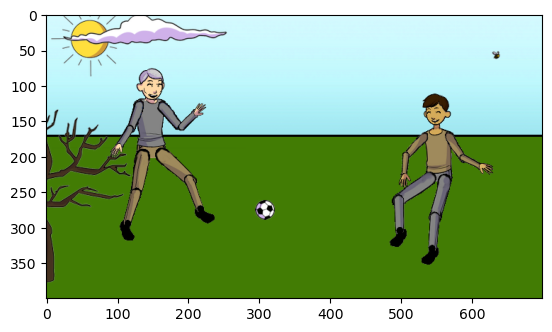

1/1 [==============================] - 0s 135ms/step
Answer     Prob
     1 0.927047
     2 0.072889
     3 0.000059
     4 0.000005
How many birds nest are in the tree?
1


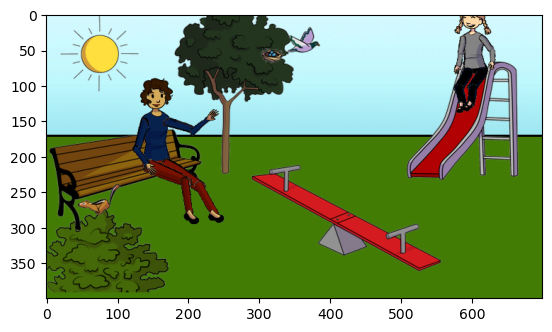

1/1 [==============================] - 0s 40ms/step
Answer         Prob
     1 9.992724e-01
     2 7.253984e-04
     3 2.205489e-06
     4 2.534028e-08
How many children?
2


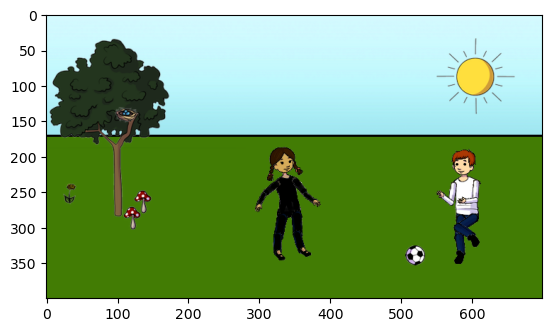

1/1 [==============================] - 0s 32ms/step
Answer         Prob
     1 9.991202e-01
     2 8.109750e-04
     3 6.832381e-05
     0 4.989208e-07
How many teapots do you see?
1


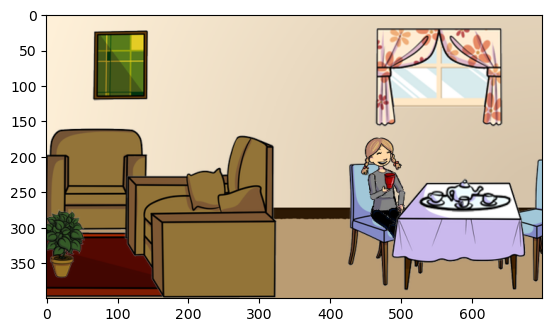

1/1 [==============================] - 0s 21ms/step
Answer     Prob
     1 0.691955
     2 0.280751
     3 0.027283
     0 0.000006
How many floral pillows are on the floor?
3


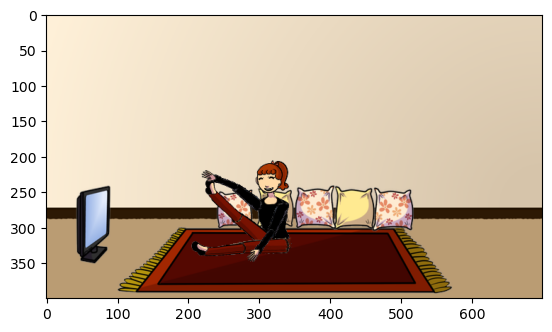

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     1 0.729969
     2 0.155219
     3 0.113985
     0 0.000609
How many mushrooms?
2


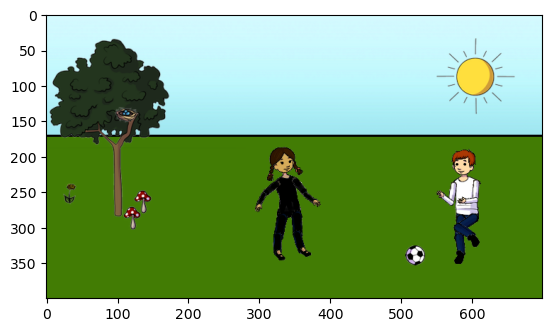

1/1 [==============================] - 0s 26ms/step
Answer     Prob
     3 0.885777
     2 0.059672
     1 0.054523
     4 0.000024
How many mushrooms?
2


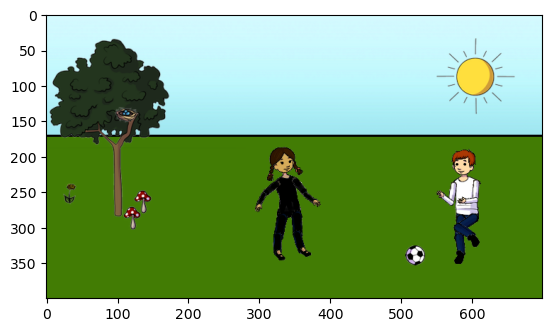

1/1 [==============================] - 0s 24ms/step
Answer     Prob
     3 0.885777
     2 0.059672
     1 0.054523
     4 0.000024
How many panes does the window have?
4


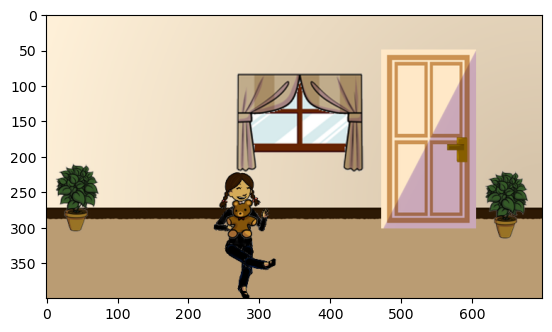

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     4 0.400528
    24 0.316721
     8 0.258692
     2 0.021496
How many bunnies are there?
1


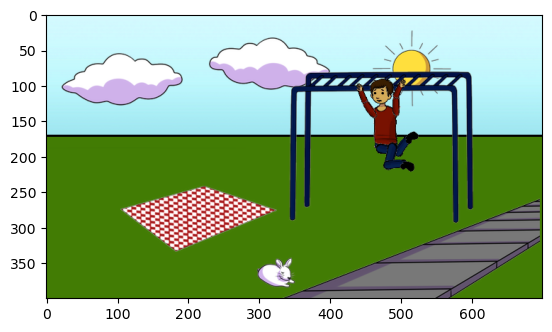

1/1 [==============================] - 0s 21ms/step
Answer     Prob
     2 0.982073
     3 0.010317
     1 0.007412
     4 0.000190
How many bunnies are there?
1


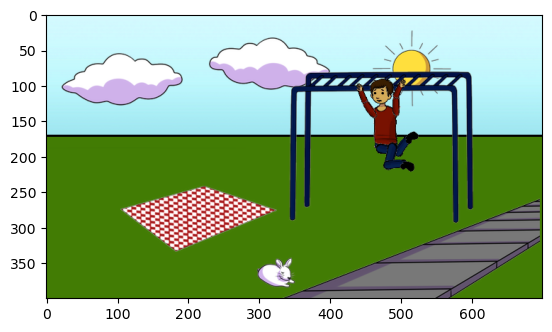

1/1 [==============================] - 0s 21ms/step
Answer     Prob
     2 0.982073
     3 0.010317
     1 0.007412
     4 0.000190
How many mushrooms?
2


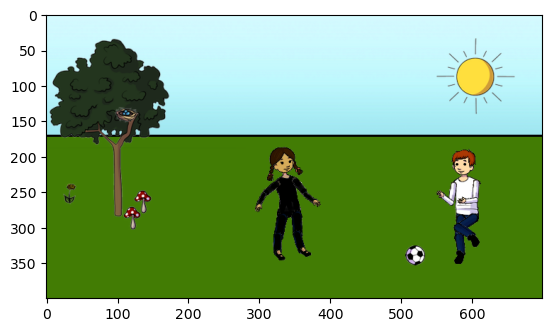

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     3 0.885777
     2 0.059672
     1 0.054523
     4 0.000024
How many steps are there on the slide?
5


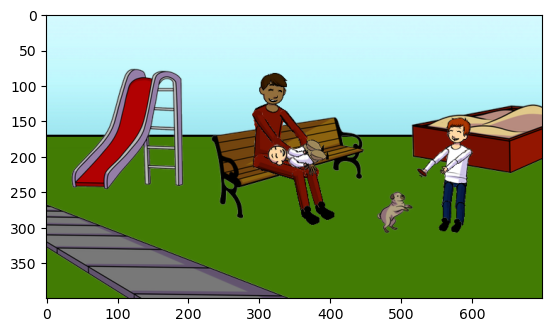

1/1 [==============================] - 0s 24ms/step
Answer         Prob
     5 9.998042e-01
     2 1.703716e-04
    25 2.546991e-05
     1 1.384988e-08
How many people in the room?
2


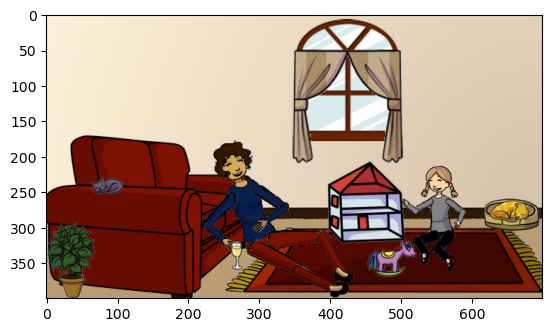

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     1 0.825519
     2 0.160853
     3 0.013478
     0 0.000145
How many girls?
1


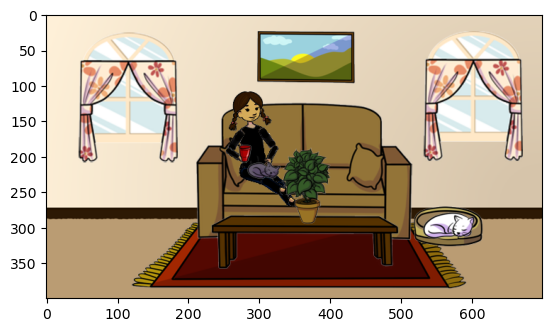

1/1 [==============================] - 0s 21ms/step
Answer     Prob
     1 0.878896
     2 0.120571
     3 0.000532
     0 0.000001
How many flowers are in the room?
0


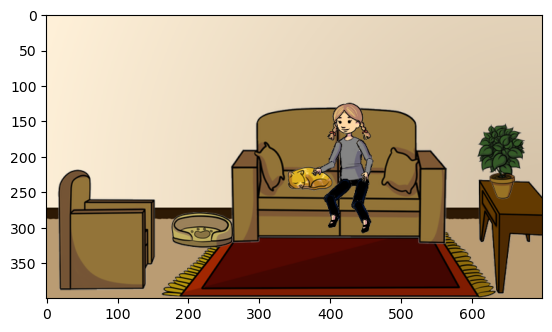

1/1 [==============================] - 0s 20ms/step
Answer     Prob
     1 0.758550
     2 0.213297
     0 0.027317
     5 0.000741
How many trees?
1


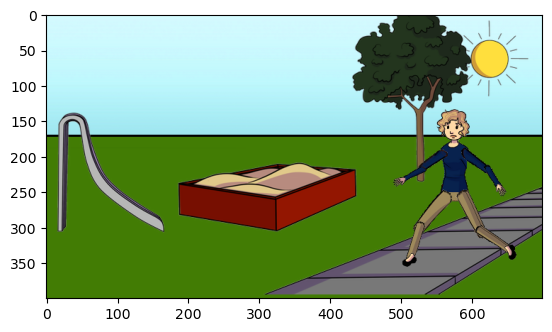

1/1 [==============================] - 0s 22ms/step
Answer         Prob
     1 9.998850e-01
     2 1.027601e-04
     0 1.190344e-05
     3 3.960473e-07
How many people?
1


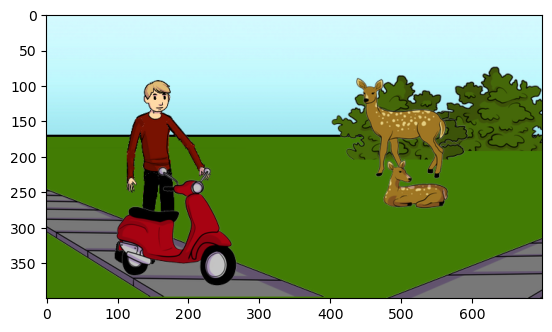

1/1 [==============================] - 0s 20ms/step
Answer         Prob
     2 9.755610e-01
     1 2.333768e-02
     3 1.101225e-03
     0 1.283273e-07
How many clouds in the sky?
3


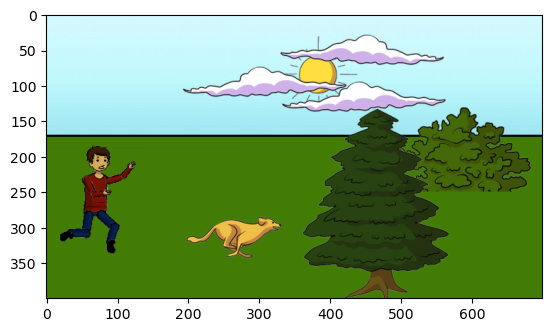

1/1 [==============================] - 0s 26ms/step
Answer     Prob
     2 0.875364
     1 0.095981
     3 0.027147
     4 0.001460
How many Teacups are on the table?
3


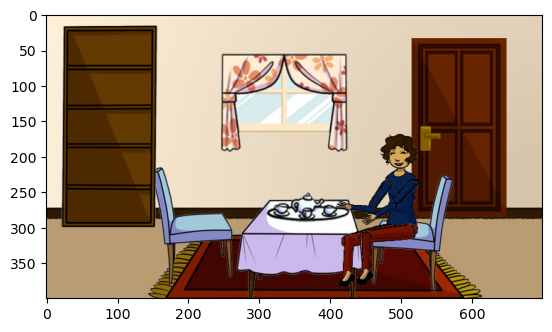

1/1 [==============================] - 0s 22ms/step
Answer         Prob
     3 9.999915e-01
     2 8.068248e-06
     1 1.782415e-07
     0 6.584339e-08
How many suns?
1


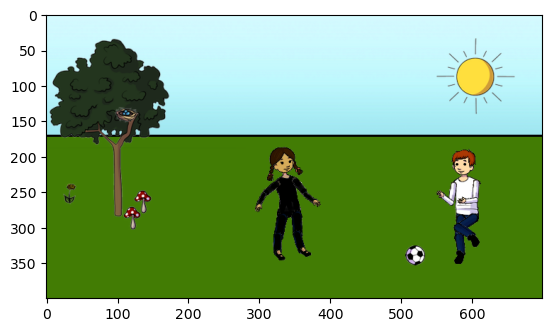

1/1 [==============================] - 0s 20ms/step
Answer         Prob
     1 4.200242e-01
     2 3.766207e-01
     3 2.033548e-01
    24 1.704832e-07
How many cats are in the picture?
2


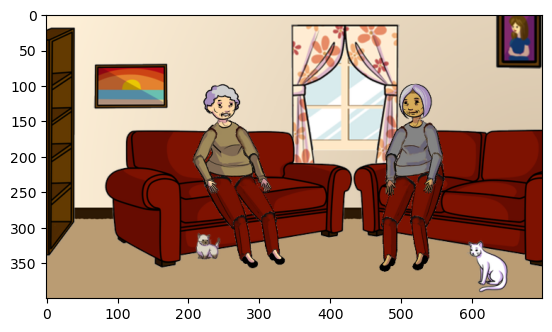

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     1 0.602795
     2 0.326593
     3 0.070529
     0 0.000058
How many people in the room?
2


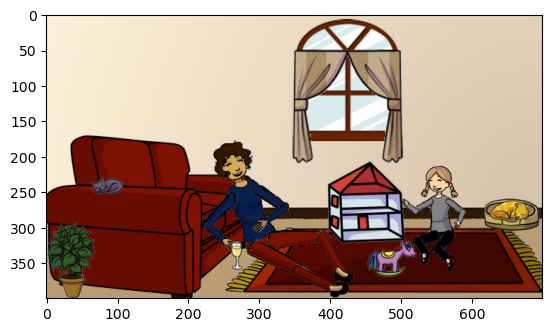

1/1 [==============================] - 0s 21ms/step
Answer     Prob
     1 0.825519
     2 0.160853
     3 0.013478
     0 0.000145
How many steps are on the sliding board?
5


KeyError: 'board?'

In [ ]:
print_predictions(30, val_df, answer_list)

### Generating Heat-Map

In [ ]:
model1 = InceptionV3(weights='imagenet')
model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

 batch_normalization_100 (Batch  (None, 35, 35, 64)  192         ['conv2d_99[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_102 (Batch  (None, 35, 35, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 35, 35, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_106 (Batch  (None, 35, 35, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_117 (Batch  (None, 35, 35, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_117[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_129 (Batch  (None, 17, 17, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_139 (Batch  (None, 17, 17, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_150 (Batch  (None, 17, 17, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_150[0][0]']
          

                                                                                                  
 batch_normalization_160 (Batch  (None, 17, 17, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_160[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_165 (Batch  (None, 17, 17, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_169 (Batch  (None, 17, 17, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_171 (Batch  (None, 8, 8, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_174[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_177[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_178[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_187[0][0]']
                                                                                                  
 batch_normalization_188 (Batch  (None, 8, 8, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 8, 8, 320)    0           ['batch_normalization_180[0][0]']
                                                                                                  
 mixed9_1 

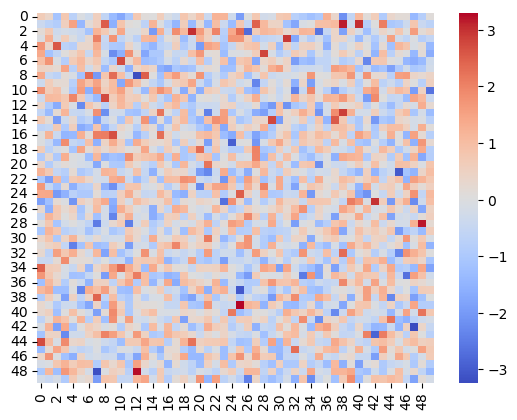

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# load the image data into a Pandas DataFrame
df = pd.DataFrame(np.random.randn(50, 50))

# generate the heatmap using Seaborn
sns.heatmap(df, cmap='coolwarm')

# display the plot
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def AM(similarity, str_arr, cmap = "RdPu"):
  DataFrame = pd.DataFrame(similarity)
  DataFrame.columns = str_arr
  DataFrame.index = str_arr
  fig, ax = plt.subplots(figsize=(8,5))
  sns.heatmap(DataFrame, cmap=cmap)

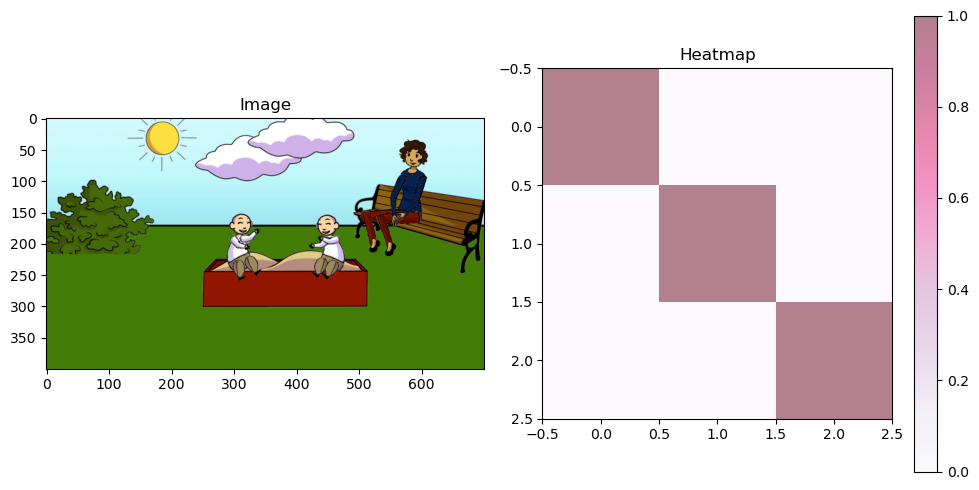

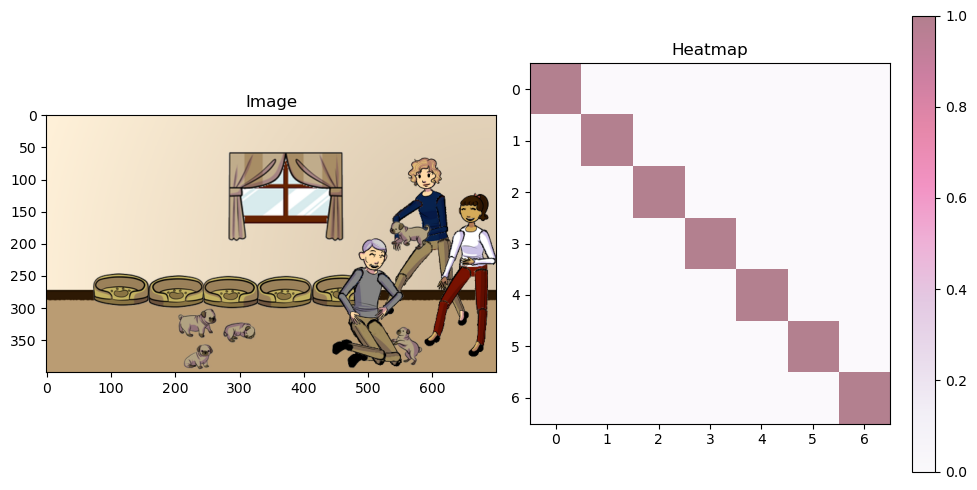

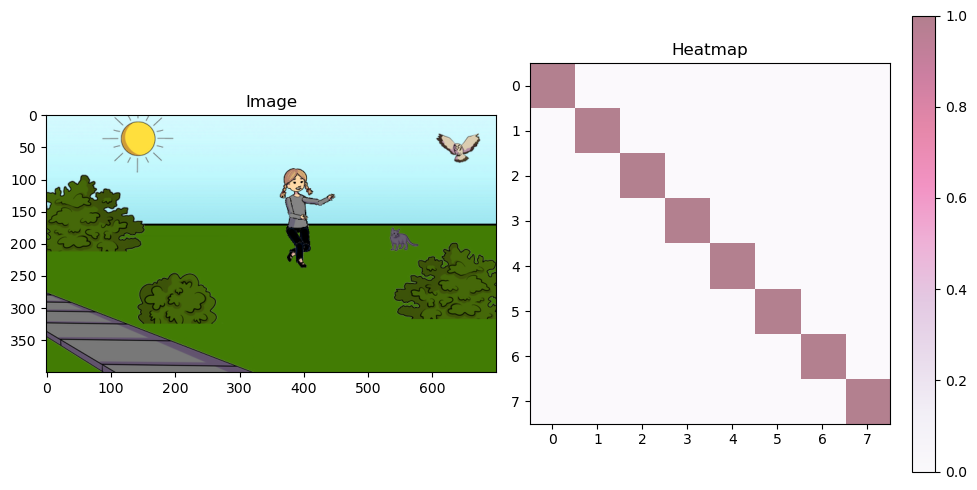

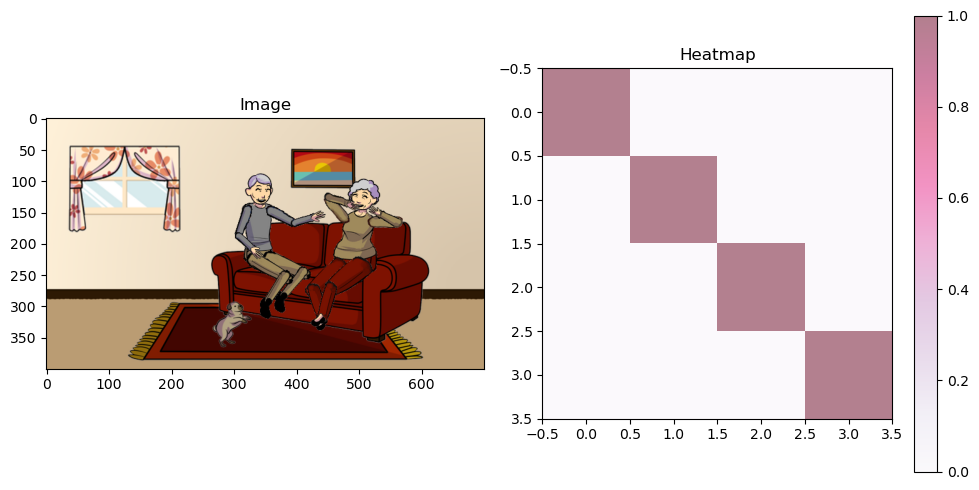

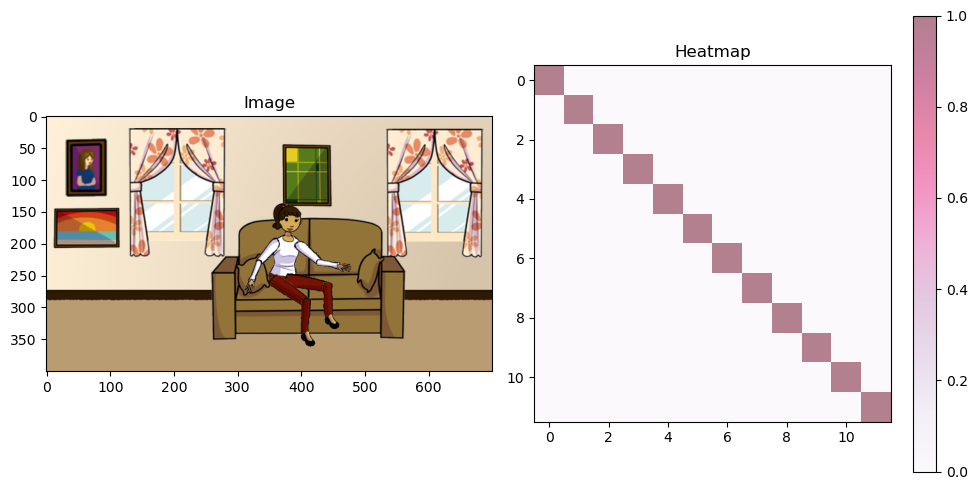

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# randomly select 5 rows from the DataFrame
df_sample = train_df.sample(5)

# iterate over the 5 random rows
for i, row in df_sample.iterrows():
    # tokenize the question text and limit to 20 characters per word
    string_txt = row['question'].split()
    str_arr = [headline[:20] for headline in string_txt]
    
    # compute the text similarity matrix using cosine similarity
    vect = CountVectorizer().fit_transform(string_txt)
    arr = vect.toarray()
    sim_mat = cosine_similarity(arr)
    
    # load the image using Matplotlib
    image = plt.imread(row['Image_path'])
    
    # create a new figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    # display the image in the first subplot
    axs[0].imshow(image)
    axs[0].set_title('Image')
    
    # display the heatmap in the second subplot
    im = axs[1].imshow(sim_mat, cmap='PuRd', alpha=0.5, interpolation='nearest')
    axs[1].set_title('Heatmap')
    
    # add a colorbar to the right of the heatmap
    fig.colorbar(im, ax=axs[1])
    
    # adjust the spacing between subplots and display the figure
    fig.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow.keras.backend as K
import tensorflow as tf

# Load the pre-trained InceptionV3 model
model1 = InceptionV3(weights='imagenet')

def ImageHeatmaps(images, intensity=0.5, res=299):
    # Load and preprocess the image
    images_ = image.load_img(images, target_size=(299, 299))
    val = image.img_to_array(images_)
    valx = np.expand_dims(val, axis=0)
    valx = preprocess_input(valx)

    # Compute the gradient of the predicted class with respect to the last convolutional layer
    with tf.GradientTape() as gradValue:
        ConvLastLayer = model1.layers[10]
        dataiter = tf.keras.models.Model([model1.inputs], [model1.output, ConvLastLayer.output])
        OutModel, ConvLastLayer = dataiter(valx)
        OutClass = OutModel[:, np.argmax(OutModel[0])]
        Gradient = gradValue.gradient(OutClass, ConvLastLayer)
        pooled_Gradient = K.mean(Gradient, axis=(0, 1, 2))

    # Generate the heatmap
    ImageHeatmaps = tf.reduce_mean(tf.multiply(pooled_Gradient, ConvLastLayer), axis=-1)
    ImageHeatmaps = np.maximum(ImageHeatmaps, 0)
    ImageHeatmaps /= np.max(ImageHeatmaps)
    ImageHeatmaps = ImageHeatmaps.reshape((-1, 1,35,35)).flatten()

    # Load and resize the original image
    img = plt.imread(images)
    img = plt.imshow(img)

    # Resize the heatmap and apply a color map
    ImageHeatmaps = np.resize(ImageHeatmaps, (img.get_array().shape[0], img.get_array().shape[1]))
    plt.imshow(ImageHeatmaps, cmap='Purples', alpha=intensity)
    
    # Add a color bar to the right of the heatmap
    plt.colorbar()

    # Display the figure
    plt.show()

# Generate 5 random image's heatmap
for i in range(5):
    rand_idx = np.random.randint(0, len(val_df))
    ImageHeatmaps(val_df['Image_path'].iloc[rand_idx])